# COVID-19 in high minority populated counties across America

### To understand how COVID-19 is effecting counties that have a high minority population I answer the following questions:
1. What is the distribution of Covid-19 cases for highly minority populated counties vs. highly non-minority populated counties in the United States?

2. What is the case gap between the worst counties when grouped by race?

3. Which counties have seen the biggest improvement (drop in cases) since their biggest recorded day?

4. Which state has the best medical response COVID-19 policies deaths vs cases?

One thing I had to do before I started my analysis was decide how I am classifying counties as high minority. I decided that if a minority race (black, hispanic, asian, or native american) makes up the majoriy of a county's population then that county is considered high minority.
One caviate to the experiment is that the covid data is only for 2020, but the data on the county demographics ends July 2019. So there is some error in population of the races in the data.

## Imports and Functions

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

def find_dominate_race(races):
    """
    races: A dictionary where the key is the race, and the value is the percentage
    of population for a given county
    
    returns: A dictionary where the key is the most prominate race and the value 
    is that race's percentage of the population
    """
    highest_population = dict()
    population = 0
    for key, val in races.items():
        if val > population:
            population = val
            highest_population[key] = val
    dom_race = list(highest_population.items())[-1]
    return dom_race

def find_highest_reported_case(cases_by_day):
    """
    cases_by_day: A list of the cumulative cases each day since cases 
    started being reported
    
    returns: A list of the number of new cases each day since the they
    started being reported
    """
    case_by_day_count = []
    for i, day in enumerate(cases_by_day):
        if i > 0:
            case_by_day_count.append(cases_by_day[i] - cases_by_day[i-1])
        else:
            case_by_day_count.append(cases_by_day[i])
    return case_by_day_count

## Step 1. Data loading 

In [2]:
cwd = os.getcwd()

#Data should be in the directory above this one. (one directoy up)
county       = cwd[:-14] + 'cc-est2019-alldata.csv'
cases        = cwd[:-14] + 'covid_confirmed_usafacts.csv'
covid_county = cwd[:-14] + 'covid_county_population_usafacts.csv'
deaths       = cwd[:-14] + 'covid_deaths_usafacts.csv'

In [3]:
# Demographics of all the counties in the United States unitl (7/1/2019)
county_demographics = pd.read_csv(county, encoding = "ISO-8859-1")

# All of the covid cases that were reported unitl (11/15/20)
covid_cases = pd.read_csv(cases, encoding = "ISO-8859-1")

# All of counties in the United States and their populations (assumed to be most recent)
county_populations = pd.read_csv(covid_county, encoding = "ISO-8859-1")

# All of the covid deaths that were reported (only using unitl 11/15/20)
covid_deaths = pd.read_csv(deaths, encoding = "ISO-8859-1")

In [65]:
import statistics
# plt.figure(figsize=(10,10))
# plt.scatter([i for i in range(len(list(county_populations[county_populations["County Name"] != "Statewide Unallocated"]["population"])))],sorted(list(county_populations[county_populations["County Name"] != "Statewide Unallocated"]["population"])))
# plt.grid(True)

# plt.figure(figsize=(10,10))
# plt.scatter([i for i in range(len(list(county_populations[county_populations["County Name"] != "Statewide Unallocated"]["population"])))],sorted(list(county_populations[county_populations["County Name"] != "Statewide Unallocated"]["population"])))
# plt.ylim(0,2000000)
# plt.grid(True)

# plt.figure(figsize=(10,10))
# plt.scatter([i for i in range(len(list(county_populations[county_populations["County Name"] != "Statewide Unallocated"]["population"])))],sorted(list(county_populations[county_populations["County Name"] != "Statewide Unallocated"]["population"])))
# plt.ylim(0,250000)
# plt.grid(True)

# plt.figure(figsize=(10,10))
# plt.scatter([i for i in range(len(list(county_populations[county_populations["County Name"] != "Statewide Unallocated"]["population"])))],sorted(list(county_populations[county_populations["County Name"] != "Statewide Unallocated"]["population"])))
# plt.ylim(0,50000)
# plt.grid(True)


## Step 2. General data preprocessing

In [40]:
# Change the name of the columns to match the other csv files
county_demographics = county_demographics.rename(columns={"CTYNAME": "County Name", "STNAME": "State"})

In [41]:
# Some of the States are represented by abbreviations, so here we replace them with the actual spelling

state_full = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 
'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 
'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 
'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 
'Virginia', 'Washington','West Virginia', 'Wisconsin', 'Wyoming']

state_abb = ['AL', 'AK', 'AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS',
'KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY',
'NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX',
'UT','VT','VA','WA','WV','WI','WY']

county_populations = county_populations.replace(state_abb, state_full)
covid_cases = covid_cases.replace(state_abb, state_full)
covid_deaths = covid_deaths.replace(state_abb, state_full)

In [71]:
p =county_populations[["County Name", "State", "population"]]
c =covid_cases[["County Name", "State", "11/15/20"]]
cp100 = c.merge(p,on=["County Name", "State"],how='left')

adjusted_cases = []
for index,row in cp100.iterrows():
    cases      = row["11/15/20"]
    population = row["population"]
    try:
        x = population/100
        cases_per_100 = cases/x
        adjusted_cases.append(cases_per_100)
    except ZeroDivisionError:
        adjusted_cases.append(cases)
        
cp100['cases'] = pd.Series(adjusted_cases, index=cp100.index)
cp100

,County Name,State,11/15/20,population,cases
0,Statewide Unallocated,Alabama,0,0.0,0.000000
1,Autauga County,Alabama,2456,55869.0,4.395998
2,Baldwin County,Alabama,7646,223234.0,3.425105
3,Barbour County,Alabama,1128,24686.0,4.569392
4,Bibb County,Alabama,986,22394.0,4.402965
...,...,...,...,...,...
3190,Sweetwater County,Wyoming,1075,42343.0,2.538790
3191,Teton County,Wyoming,1178,23464.0,5.020457
3192,Uinta County,Wyoming,729,20226.0,3.604272
3193,Washakie County,Wyoming,218,7805.0,2.793081


In [7]:
# Need to extract the appropriate years, and age groups

df = county_demographics 
by_age = df[df["AGEGRP"] == 0] #All ages
by_age_year = by_age[by_age["YEAR"] == 12] # Looks at 2019

In [8]:
# Only grabbing the races we are interested in from the dataset (Asian, White, Black, Hispanic, Native American)
by_race_age_year = by_age_year[['County Name', 'AGEGRP', 'State','TOT_MALE', 'TOT_FEMALE',
'WA_FEMALE', 'WA_MALE', 'AA_FEMALE', 'AA_MALE', 'BA_FEMALE', 'BA_MALE',
'IA_FEMALE','IA_MALE', 'H_FEMALE','H_MALE']]


In [9]:
# Adding the male and female populations together to get the total population for a race
by_race_age_year["White"] = np.add(list(by_race_age_year["WA_FEMALE"]), list(by_race_age_year["WA_MALE"]))
by_race_age_year["Asian"] = np.add(list(by_race_age_year["AA_FEMALE"]), list(by_race_age_year["AA_MALE"]))
by_race_age_year["Black"] = np.add(list(by_race_age_year["BA_FEMALE"]), list(by_race_age_year["BA_MALE"]))
by_race_age_year["Native American"] = np.add(list(by_race_age_year["IA_FEMALE"]), list(by_race_age_year["IA_MALE"]))
by_race_age_year["Hispanic"] = np.add(list(by_race_age_year["H_FEMALE"]), list(by_race_age_year["H_MALE"]))
by_race_age_year["total pop"] = np.add(list(by_race_age_year["TOT_FEMALE"]), list(by_race_age_year["TOT_MALE"]))

demographics = by_race_age_year[['County Name', 'total pop', 'State', 'White', 'Asian', 'Black', 'Native American', 'Hispanic']]

C:\Users\Matth\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Matth\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Matth\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [10]:
# Some of the States are represented by abbreviations, so here we replace them with the actual spelling
demographics = demographics.replace(state_abb, state_full)

# Some states have spaces in them so they are replaced by _ in order to make processing easier
double_states = ['District of Columbia', 'West Virginia', 'Rhode Island', 'South Carolina', 'South Dakota', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'District of Columbia']
single_states = ['District_of_Columbia', 'West_Virginia', 'Rhode_Island', 'South_Carolina', 'South_Dakota', 'New_Hampshire', 'New_Jersey', 'New_Mexico', 'New_York', 'North_Carolina', 'North_Dakota', 'District_of_Columbia']
covid_cases = covid_cases.replace(double_states, single_states)
demographics = demographics.replace(double_states, single_states)
covid_deaths = covid_deaths.replace(double_states, single_states)

## Step 3. Asnwering questions
### Question 1 process

In [11]:
# Get all the counties that are high minority and high majority
minority_counties = []
non_minority_counties = []
for i in range(len(demographics)):
    row = demographics.iloc[i,:]
    races = {"White": row['White']/row['total pop'], "Asian": row['Asian']/row['total pop'], "Black": row['Black']/row['total pop'],
                "Native American": row['Native American']/row['total pop'], "Hispanic": row['Hispanic']/row['total pop']}

    dominate_race = find_dominate_race(races)
    if dominate_race[0] != "White":
        minority_counties.append(row['County Name'] + " " + row["State"])
    else:
        non_minority_counties.append(row['County Name'] + " " + row["State"])  
        

# Get the number of reported coronavirus cases for each county
all_counties = dict()
for i in range(len(covid_cases[['County Name', 'State', '11/15/20']])):
    row = covid_cases[['County Name', 'State', '11/15/20']].iloc[i,:]
    all_counties[row['County Name'] + " " + row["State"]] = row['11/15/20']

In [12]:
covid_percentage = dict()
m_counties = minority_counties + non_minority_counties
print("Counties that are not in both datasets: ")
# Looks at the percentage of coronavirus cases in each county
for key, cases in all_counties.items():
    key_list = key.split()
    county = ""
    
    for i in range(len(key_list) -1):
        county += key_list[i] + " "
    # Gets the county and State in the covid cases dataset
    county = county[:-1]
    state = key_list[-1]
    
    
    if key_list[0] != "Statewide":
        if str(county + " " + state) in m_counties:
            if len(demographics[(demographics["County Name"] == county) & (demographics["State"] == state)]['total pop']) > 0:
                covid_percentage[key] = cases/int(demographics[(demographics["County Name"] == county) & (demographics["State"] == state)]['total pop'])
        else:
            print(county, state)
                

Counties that are not in both datasets: 
Municipality of Anchorage Alaska
City and Borough of Juneau Alaska
Petersburg Census Area Alaska
Wade Hampton Census Area Alaska
Grand Princess Cruise Ship California
Broomfield County and City Colorado
Washington District_of_Columbia
La Salle Parish Louisiana
Baltimore City Maryland
Lac Qui Parle County Minnesota
Jackson County (including other portions of Kansas City) Missouri
City of St. Louis Missouri
Dona Ana County New_Mexico
New York City Unallocated/Probable New_York
Matthews County Virginia
Alexandria City Virginia
Charlottesville City Virginia
Chesapeake City Virginia
Danville City Virginia
Fredericksburg City Virginia
Harrisonburg City Virginia
Manassas City Virginia
Newport News City Virginia
Norfolk City Virginia
Portsmouth City Virginia
Richmond City Virginia
Suffolk City Virginia
Virginia Beach City Virginia
Williamsburg City Virginia


In [13]:

minority_covid_percentages = []
for county in minority_counties:
    try:
        minority_covid_percentages.append(covid_percentage[county])
    except KeyError:
        continue
majority_covid_percentages = []
for county in non_minority_counties:
    try:
        majority_covid_percentages.append(covid_percentage[county])
    except KeyError:
        continue

### What is the distribution of Covid-19 cases for highly minority populated counties vs. highly non-minority populated counties in the United States?

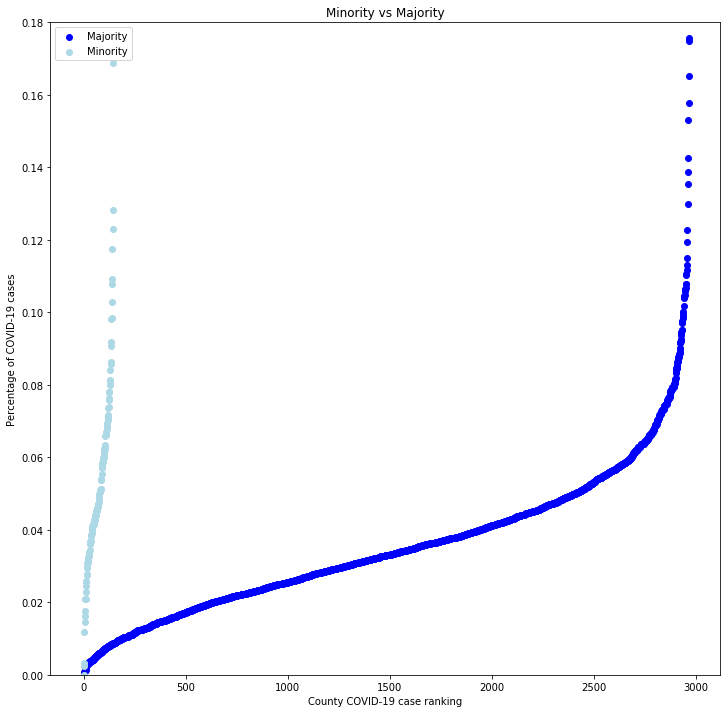

In [14]:
# fig = plt.figure(figsize=(8,8))
# plt.ylim((0, .18))
# plt.scatter([i for i in range(len(majority_covid_percentages) + len(minority_covid_percentages))], [0]*(len(majority_covid_percentages)) +sorted(minority_covid_percentages))
# fig = plt.figure(figsize=(8,8))
# plt.ylim((0, .18))
# plt.scatter([i for i in range(len(majority_covid_percentages)+ len(minority_covid_percentages))], [0]*(len(minority_covid_percentages)) +sorted(majority_covid_percentages))
fig = plt.figure(figsize=(12,12))
plt.ylim((0, .18))
MA_X = [i for i in range(len(majority_covid_percentages))]
MA_Y = sorted(majority_covid_percentages)
plt.scatter(MA_X, MA_Y, c='blue')
MI_X =[i for i in range(len(minority_covid_percentages))]
MI_Y = sorted(minority_covid_percentages)
plt.scatter(MI_X, MI_Y, c='lightblue')
plt.legend(['Majority', 'Minority'])
plt.title("Minority vs Majority")
plt.ylabel("Percentage of COVID-19 cases")
plt.xlabel("County COVID-19 case ranking")
plt.savefig("Minor_v_Major")
plt.show()

The distribution for the majority counties looks linear for the most part, except towards the end where it looks like its increasing exponentially. My assumption that the minority county distribution would look exponential when compared to the majorit was right. 
### Question 2 process 

In [16]:
black_counties    = dict()
hispanic_counties = dict()
white_counties    = dict()
asian_counties    = dict()
native_counties   = dict()
for i in range(len(demographics)):
    row = demographics.iloc[i,:]
    races = {"White": row['White']/row['total pop'], "Asian": row['Asian']/row['total pop'], "Black": row['Black']/row['total pop'],
                "Native American": row['Native American']/row['total pop'], "Hispanic": row['Hispanic']/row['total pop']}
    dominate_race = find_dominate_race(races)
    
    try:
        if dominate_race[0] == "White":
            white_counties[row['County Name'] + " " + row["State"]] = all_counties[row['County Name'] + " " + row["State"]]

        elif dominate_race[0] == "Black":
            black_counties[row['County Name'] + " " + row["State"]] = all_counties[row['County Name'] + " " + row["State"]]

        elif dominate_race[0] == "Hispanic":
            hispanic_counties[row['County Name'] + " " + row["State"]] = all_counties[row['County Name'] + " " + row["State"]]

        elif dominate_race[0] == "Asian":
            asian_counties[row['County Name'] + " " + row["State"]] = all_counties[row['County Name'] + " " + row["State"]]

        elif dominate_race[0] == "Native American":
            native_counties[row['County Name'] + " " + row["State"]] = all_counties[row['County Name'] + " " + row["State"]]
    except KeyError:
        continue
        #print(row['County Name'] + " " + row["State"])

In [17]:
sorted_white_covoid_counties = dict(sorted(white_counties.items(), key=lambda item: item[1]))
sorted_black_covoid_counties = dict(sorted(black_counties.items(), key=lambda item: item[1]))
sorted_hispanic_covoid_counties = dict(sorted(hispanic_counties.items(), key=lambda item: item[1]))
sorted_asian_covoid_counties = dict(sorted(asian_counties.items(), key=lambda item: item[1]))
sorted_native_covoid_counties = dict(sorted(native_counties.items(), key=lambda item: item[1]))

### What is the case gap between the worst counties when grouped by race?

In [18]:
print("White people:")
for i, (county, case_count) in enumerate(sorted_white_covoid_counties.items()):
    if i == 0:
        print(county, case_count)
        lowest = case_count
    elif i == len(sorted_white_covoid_counties) - 1:
        print(county, case_count)
        highest = case_count
print("Gap: ", highest - lowest)
print(" ")

print("Black people:")
for i, (county, case_count) in enumerate(sorted_black_covoid_counties.items()):
    if i == 0:
        print(county, case_count)
        lowest = case_count
    elif i == len(sorted_black_covoid_counties) - 1:
        print(county, case_count)
        highest = case_count
print("Gap: ", highest - lowest)
print(" ")

print("Hispanic people:")
for i, (county, case_count) in enumerate(sorted_hispanic_covoid_counties.items()):
    if i == 0:
        print(county, case_count)
        lowest = case_count
    elif i == len(sorted_hispanic_covoid_counties) - 1:
        print(county, case_count)
        highest = case_count
print("Gap: ", lowest)
print(" ")

print("Asian people:")
for i, (county, case_count) in enumerate(sorted_asian_covoid_counties.items()):
    if i == 0:
        print(county, case_count)
        lowest = case_count
    elif i == len(sorted_asian_covoid_counties) - 1:
        print(county, case_count)
        highest = case_count
print("Gap: ", highest - lowest)
print(" ")

print("Native American people:")
for i, (county, case_count) in enumerate(sorted_native_covoid_counties.items()):
    if i == 0:
        print(county, case_count)
        lowest = case_count
    elif i == len(sorted_native_covoid_counties) - 1:
        print(county, case_count)
        highest = case_count
print("Gap: ", highest - lowest)
print(" ")

White people:
Bristol Bay Borough Alaska 0
Los Angeles County California 339560
Gap:  339560
 
Black people:
Taliaferro County Georgia 32
Shelby County Tennessee 42660
Gap:  42628
 
Hispanic people:
Bronx County New_York 58712
Gap:  58712
 
Asian people:
Aleutians East Borough Alaska 11
Honolulu County Hawaii 14261
Gap:  14250
 
Native American people:
Yakutat City and Borough Alaska 0
Robeson County North_Carolina 6672
Gap:  6672
 


### Question 3 process 

In [19]:
cases_per_day = dict()
for i in range(len(covid_cases)):
    row = covid_cases.iloc[i,1:]
    if row["County Name"] != "Statewide Unallocated":
        dates = list(row[3:])

        cases_a_day = find_highest_reported_case(dates)

        highest_day = cases_a_day.index(max(cases_a_day))
        highest_count = max(cases_a_day)
        
        if highest_day == 298:
            cases_per_day[row["County Name"] +" "+ row["State"]] = 0
        else:
            average_cases_after_peak = sum(cases_a_day[highest_day+1:])/len(cases_a_day[highest_day+1:])
            cases_per_day[row["County Name"] +" "+ row["State"] + " " + str(len(cases_a_day[highest_day+1:]))] = average_cases_after_peak

### Which counties have seen the biggest improvement (drop in cases) since their biggest recorded day?

In [20]:
scases_per_day = dict(sorted(cases_per_day.items(), key=lambda item: item[1])) # The resason why we have some negative numbers is because some people entered in a negative number of cases for a day.
for key, val in scases_per_day.items():
    if val < 0.05 and val > 0:
        
        county_state = ""
        key_list = key.split()
        for i in range(len(key_list) -1):
            county_state += key_list[i] + " "
        county_state = county_state[:-1]

        if county_state in list(sorted_white_covoid_counties.keys()):
            race = "(Non-minority)"
        else:
            race = "(Minority)"
        print('{:40} {} {}'.format(key,race, val))
        


Hinsdale County Colorado 239             (Non-minority) 0.012552301255230125
Dolores County Colorado 121              (Non-minority) 0.01652892561983471
Banner County Nebraska 159               (Non-minority) 0.03773584905660377
Jackson County Colorado 128              (Non-minority) 0.0390625


Hinsdale County Colorado and Dolores County Colorado with after 239 and 121 days they have an average case count of 0.01. Then Banner County Nebraska and Jackson County Colorado, after 159 and 128 days they have 0.03 and 0.039 cases per day respectfully.

### Question 4 process

In [21]:
county_deaths = covid_deaths[["County Name", "State", "11/15/20"]]
county_cases  = covid_cases[["County Name", "State", "11/15/20"]]


In [22]:
response = dict()
for state in list(set(county_deaths["State"])):
    death_count = sum(covid_deaths[covid_deaths["State"] == state]["11/15/20"])
    case_count = sum(covid_cases[covid_cases["State"] == state]["11/15/20"])
    response[state] =  death_count/case_count

In [23]:
best_response = dict(sorted(response.items(), key=lambda item: item[1]))
for key, val in best_response.items():
    if val < 0.01:
        print('{:40} {}'.format(key, val))

Alaska                                   0.004324419733474539
Utah                                     0.004679153073293734
Wyoming                                  0.005468124833288877
Wisconsin                                0.007992749845418945
Nebraska                                 0.008000739477846476
Idaho                                    0.009216365736518937
South_Dakota                             0.0098499564093544
Oklahoma                                 0.009913837849060522


### Which state has the best medical response COVID-19 policies deaths vs cases?

Alaska with a total rate of 0.0043 deaths per case

## Future Work 
### Checking what the results would be if you classify a county as high minority if the percentage of minorities is above 50%, and doing the CDC method of cases/100k people instead of using total population.